
Ao lado dos campos: Nome, Plataforma, Ano de Lançamento, Gênero, Editora, Vendas NA , Vendas da UE , Vendas JP , Outras Vendas, Vendas Globais, temos:-

Critic_score - Pontuação agregada compilada pela equipe do Metacritic

Contagem de críticos - O número de críticos usados para criar a pontuação da crítica

User_score - Pontuação dos assinantes do Metacritic

Contagem de usuários - Número de usuários que deram a pontuação do usuário

Desenvolvedor - Parte responsável pela criação do jogo

Classificação - As classificações ESRB | E=Todos os públicos - E10+ = Maiores de 10 anos | T = Acima de 13 anos |  M = Acima de 17 anos | AO = Adultos | RP = Não foi rotulado

Reconhecimentos

Este repositório, https://github.com/wtamu-cisresearch/scraper , após alguns ajustes funcionou extremamente bem!

## **Importando os dados:**

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import KFold
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')


In [200]:
df = pd.read_csv("games.csv")

In [201]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Developer,Rating
0,Wii Sports,Wii,2006.0,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53,76.0,51.0,8,322.0,Nintendo,E
1,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24,NaN,NaN,NaN,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,Nintendo,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,Nintendo,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN,NaN


**Verificando se há dados nulos:**

In [202]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16719 entries, 0 to 16718
Data columns (total 16 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16717 non-null  object 
 1   Platform         16719 non-null  object 
 2   Year_of_Release  16450 non-null  float64
 3   Genre            16717 non-null  object 
 4   Publisher        16665 non-null  object 
 5   NA_Sales         16719 non-null  float64
 6   EU_Sales         16719 non-null  float64
 7   JP_Sales         16719 non-null  float64
 8   Other_Sales      16719 non-null  float64
 9   Global_Sales     16719 non-null  float64
 10  Critic_Score     8137 non-null   float64
 11  Critic_Count     8137 non-null   float64
 12  User_Score       10015 non-null  object 
 13  User_Count       7590 non-null   float64
 14  Developer        10096 non-null  object 
 15  Rating           9950 non-null   object 
dtypes: float64(9), object(7)
memory usage: 2.0+ MB


**Agora excluir a coluna "Developer" pois é semelhante a "Publisher"**

In [203]:
df.drop(columns="Developer", axis=1, inplace=True)

**Neste caso específico vamos retirar os dados nulos, pois alguns representam mais de 50% das amostras, não irão servir paa fazer a previsão se os aods nulos forem substituídos.**

In [204]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8582
Critic_Count       8582
User_Score         6704
User_Count         9129
Rating             6769
dtype: int64

**Verificando se há duplicatas...**

In [205]:
df.duplicated().sum()

0

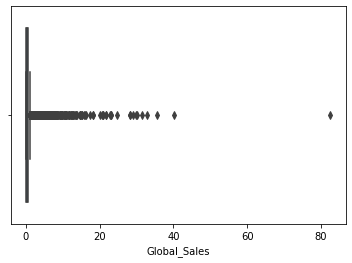

In [207]:
sns.boxplot(df["Global_Sales"]);

**Vamos retirar algumas outliers, apenas 2 amostras:**

In [208]:
lista = ["NA_Sales", "EU_Sales", "JP_Sales", "Other_Sales", "Global_Sales"]
for i in df[lista]:
  df = df[df[i] < 40]

In [209]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
2,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52,82.0,73.0,8.3,709.0,E
3,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77,80.0,73.0,8,192.0,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37,NaN,NaN,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,Nintendo,23.20,2.26,4.22,0.58,30.26,NaN,NaN,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,Nintendo,11.28,9.14,6.50,2.88,29.80,89.0,65.0,8.5,431.0,E
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,Samurai Warriors: Sanada Maru,PS3,2016.0,Action,Tecmo Koei,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN
16715,LMA Manager 2007,X360,2006.0,Sports,Codemasters,0.00,0.01,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN
16716,Haitaka no Psychedelica,PSV,2016.0,Adventure,Idea Factory,0.00,0.00,0.01,0.00,0.01,NaN,NaN,NaN,NaN,NaN
16717,Spirits & Spells,GBA,2003.0,Platform,Wanadoo,0.01,0.00,0.00,0.00,0.01,NaN,NaN,NaN,NaN,NaN


#**XGBOOST**

In [210]:
#Separando o que é features e target:
X = df.drop(columns="Global_Sales")
y = df["Global_Sales"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=12)

# Iniciando a construção da Pipeline:
# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()
# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com o One Hot Encoder e Ordinal Enconder. Percebemos que o One Hot Encoder 
# é para features categóricas binárias e o Ordinal Enconder para features categóricas ordinais (não binários)

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                             ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

features_oe = ["Name", "Platform", "Genre", "Publisher", "User_Score", "Rating"]

# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat_oe", pipe_features_oe, features_oe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_xgbr = Pipeline([("pre_processador", pre_processador),
                     ("xgbr", XGBRegressor(eval_metric='logloss', random_state=42))])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=5, random_state=42, shuffle=True)

#Montando a grade de parâmetros do estimador (XGBoost)
params_grid_xgbr = {"xgbr__n_estimators": [2000],
                   "xgbr__max_depth": [2],
                   "xgbr__learning_rate": [0.001],
                   "xgbr__colsample_bytree": [0.5],
                   "xgbr__subsample": [0.5]}


#Motando a grade geral de parâmetros.
grid_xgbr = GridSearchCV(estimator=pipe_xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

grid_xgbr.fit(X_train, y_train)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[15:33:21] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['Year_of_Release',
                                                                          'NA_Sales',
                                                                          'EU_Sales',
                                                                          'JP_Sales',
                  

In [211]:
grid_xgbr.best_params_

{'xgbr__colsample_bytree': 0.5,
 'xgbr__learning_rate': 0.001,
 'xgbr__max_depth': 2,
 'xgbr__n_estimators': 2000,
 'xgbr__subsample': 0.5}

In [212]:
xgbr_results = pd.DataFrame(grid_xgbr.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_xgbr__colsample_bytree,param_xgbr__learning_rate,param_xgbr__max_depth,param_xgbr__n_estimators,param_xgbr__subsample,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,10.431548,1.498237,0.132585,0.028718,0.5,0.001,2,2000,0.5,"{'xgbr__colsample_bytree': 0.5, 'xgbr__learnin...",0.865367,0.832005,0.884914,0.893617,0.902447,0.87567,0.025049,1


In [213]:
# Predições de treino
y_pred_train = grid_xgbr.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# Predições de teste
y_pred_test= grid_xgbr.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.90
MAE: 0.20
RMSE: 0.45

Métricas de teste:

R^2: 0.88
MAE: 0.19
RMSE: 0.45


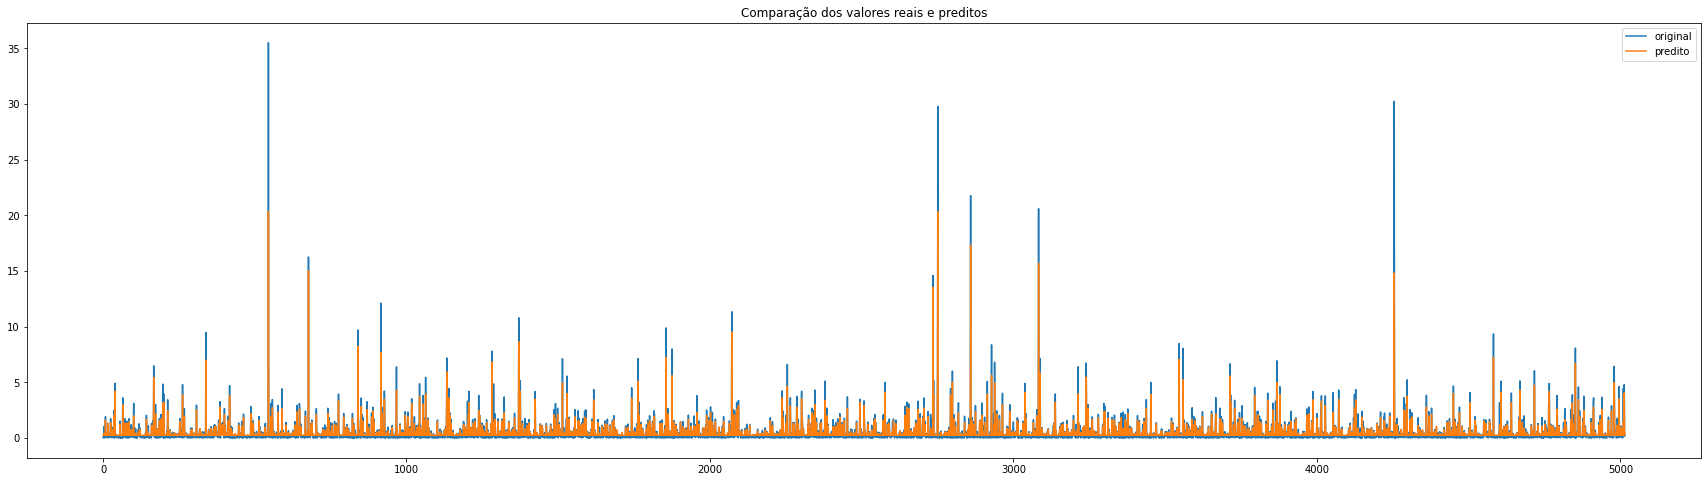

In [214]:
plt.figure(figsize=(30,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="original")
plt.plot(x_ax, y_pred_test, label="predito")
plt.title("Comparação dos valores reais e preditos")
plt.legend()
plt.show();

Salvado o estimador...

In [58]:
import pickle

In [215]:
with open("grid_xgbr.pkl", "wb") as f:
    pickle.dump(grid_xgbr, f)

In [ ]:
with open("grid_xgbr.pkl", "rb") as f:
    
    grid_xgbr = pickle.load(f)

[19:54:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [222]:
tabela_xgbr = pd.DataFrame()

In [223]:
tabela_xgbr["valores em euros"] = y_test

In [224]:
tabela_xgbr["valores preditos"] = y_pred_test

In [225]:
tabela_xgbr

,valores em euros,valores preditos
12094,0.07,0.245434
14118,0.04,0.245434
9516,0.13,0.245434
13727,0.04,0.245434
1920,1.07,0.434696
...,...,...
7122,0.22,0.245434
8575,0.16,0.246668
220,4.80,4.066635
8068,0.18,0.249204


Salvando a tabela...

In [226]:
tabela_xgbr.to_csv("08-games_xgbr.csv")

#**Interpretando o modelo globalmente**

**Para a interpretação só podemos considerar as features numéricas, vamos retirar as features categóricas:**

Percebemos que as features que tem dados como números contínuos tem um maior impacto na interpretação do que as features com dados como números discretos e as features com os maiores valores pesam mais na saída final, se analisarmos no dataset veremos que os valores da feature 'rent amount' são maiores que 'hoa' e assim sucessivamente como vemos no gráfico final:

**SHAP**

In [ ]:
!pip install shap
import shap

In [230]:
df.isna().sum()

Name                  2
Platform              0
Year_of_Release     269
Genre                 2
Publisher            54
NA_Sales              0
EU_Sales              0
JP_Sales              0
Other_Sales           0
Global_Sales          0
Critic_Score       8581
Critic_Count       8581
User_Score         6703
User_Count         9128
Rating             6768
dtype: int64

**Agora vamos tratar o NaN nas Features categóricas**

In [233]:
#"User_Score", "Publisher", "Rating"
ss = SimpleImputer(strategy="constant", fill_value="unknown")
ss.fit(df[["Publisher", "User_Score", "Rating"]])

m = ss.transform(df[["Publisher", "User_Score", "Rating"]])
df[["Publisher", "User_Score", "Rating"]] = m

**Agora vamos tratar o NaN nas Features numéricas**

In [237]:
#"Year_of_Release" "Critic_Score", "Critic_Count", "User_Count"
ss = SimpleImputer(missing_values=np.nan, strategy="median")
ss.fit(df[["Year_of_Release", "Critic_Score", "Critic_Count", "User_Count"]])

m = ss.transform(df[["Year_of_Release", "Critic_Score", "Critic_Count", "User_Count"]])
df[["Year_of_Release", "Critic_Score", "Critic_Count", "User_Count"]] = m

**O Shap só aceita dados numéricos, vamos transformar as Features categóricas em numéricas.**

**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [235]:
# "dateCrawled", "vehicleType", "lastSeen", "brand", "model",  "fuelType", "notRepairedDamage", "gearbox"
oe =  OrdinalEncoder()
oe.fit(df[["Publisher", "User_Score", "Rating", "Name", "Platform", "Genre"]])
df[["Publisher", "User_Score", "Rating", "Name", "Platform", "Genre"]] = oe.transform(df[["Publisher", "User_Score", "Rating", "Name", "Platform", "Genre"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [239]:
df.columns

Index(['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales',
       'EU_Sales', 'JP_Sales', 'Other_Sales', 'Global_Sales', 'Critic_Score',
       'Critic_Count', 'User_Score', 'User_Count', 'Rating'],
      dtype='object')

In [241]:
ssc = StandardScaler()

ssc.fit(df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales', 'EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score', 'Critic_Count', 'User_Score', 'User_Count', 'Rating']])
h= ssc.transform(df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales','EU_Sales', 'JP_Sales', 'Global_Sales', 'Critic_Score','Critic_Count', 'User_Score', 'User_Count', 'Rating']])
df[['Name', 'Platform', 'Year_of_Release', 'Genre', 'Publisher', 'NA_Sales','EU_Sales', 'JP_Sales', 'Other_Sales', 'Critic_Score','Critic_Count', 'User_Score', 'User_Count', 'Rating']] = h

In [243]:
df

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,Critic_Count,User_Score,User_Count,Rating
2,-0.063714,1.212135,0.257833,0.288651,0.361109,21.569802,28.007739,12.251659,202.761698,35.52,1.226360,3.656494,-0.191536,1.618844,-1.468157
3,1.570027,1.212135,0.429370,1.351147,0.361109,21.471891,23.945398,10.568839,187.042946,32.77,1.021789,3.656494,-0.367905,0.273834,-1.468157
4,0.468306,-1.291048,-1.800604,0.554275,0.361109,15.401348,19.416888,33.468386,179.040672,31.37,0.101215,-0.193038,0.749095,-0.163229,0.890047
5,1.181853,-1.291048,-3.001359,0.023027,0.361109,32.088347,4.699228,13.670507,172.696012,30.26,0.101215,-0.193038,0.749095,-0.163229,0.890047
6,0.281397,-1.410247,-0.085240,-0.242598,0.361109,15.415335,19.971852,21.193701,170.066693,29.80,1.942362,3.064259,-0.073957,0.895609,-1.468157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16714,0.752708,0.139343,1.630125,-1.305094,1.154166,-0.362482,-0.317652,-0.221005,-0.210265,0.01,0.101215,-0.193038,0.749095,-0.163229,0.890047
16715,-0.199186,1.450534,-0.085240,1.351147,-1.146816,-0.362482,-0.295453,-0.254002,-0.210265,0.01,0.101215,-0.193038,0.749095,-0.163229,0.890047
16716,-0.578986,0.496940,1.630125,-1.039470,-0.353759,-0.362482,-0.317652,-0.221005,-0.210265,0.01,0.101215,-0.193038,0.749095,-0.163229,0.890047
16717,0.957561,-1.171848,-0.599849,-0.242598,1.411071,-0.348494,-0.317652,-0.254002,-0.210265,0.01,0.101215,-0.193038,0.749095,-0.163229,0.890047


**Separar em features e target...**

In [244]:
X = df.drop(columns="Global_Sales")
y = df["Global_Sales"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [245]:
xgbr = XGBRegressor().fit(X_train, y_train)

[15:45:20] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [246]:
explainer = shap.TreeExplainer(xgbr)

In [247]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

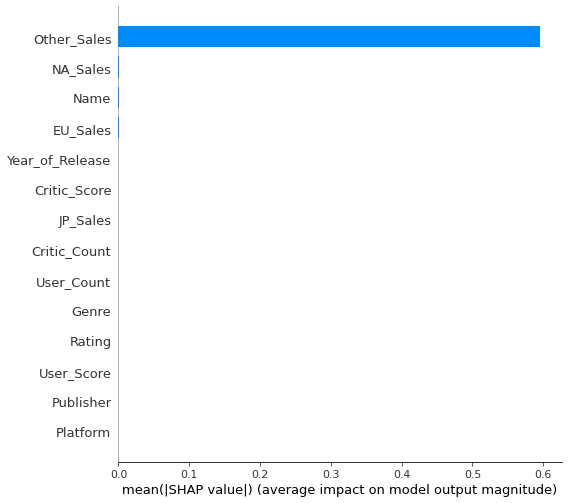

In [248]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")